# Self-Driving Car Engineer Nanodegree Program
## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[//]: # (Image References)

[im01]: ./output_images/01-calibration.png "Chessboard Calibration"
[im02]: ./output_images/02-undistort_chessboard.png "Undistorted Chessboard"
[im03]: ./output_images/03-undistort.png "Undistorted Dashcam Image"
[im04]: ./output_images/04-unwarp.png "Perspective Transform"
[im05]: ./output_images/05-colorspace_exploration.png "Colorspace Exploration"
[im06]: ./output_images/09-sobel_magnitude_and_direction.png "Sobel Magnitude & Direction"
[im07]: ./output_images/11-hls_l_channel.png "HLS L-Channel"
[im08]: ./output_images/12-lab_b_channel.png "LAB B-Channel"
[im09]: ./output_images/13-pipeline_all_test_images.png "Processing Pipeline for All Test Images"
[im10]: ./output_images/14-sliding_window_polyfit.png "Sliding Window Polyfit"
[im11]: ./output_images/15-sliding_window_histogram.png "Sliding Window Histogram"
[im12]: ./output_images/16-polyfit_from_previous_fit.png "Polyfit Using Previous Fit"
[im13]: ./output_images/17-draw_lane.png "Lane Drawn onto Original Image"
[im14]: ./output_images/18-draw_data.png "Data Drawn onto Original Image"

[video1]: ./project_video_output.mp4 "Video"

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points
*Here I will consider the rubric points individually and describe how I addressed each point in my implementation.*


### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

TFirst the object points in 3D cartesian coordinate of the chessboard has to be given, with the assumption of the chessboard on x-y plane with z=0. As the same chessboard is used for all images, the obj points are the same for all test images. Then for each image, using the cv2.findChessboardCorners() function to provide corners of each grid in the chessboard. Combining both object points and corners for all images in two lists, we then feed these lists to calibrateCamera() function to compute camera calibration and distortion coefficients. Afterwards, subsequent images can be corrected by undistort() function.


*Note: Some of the chessboard images don't appear because `findChessboardCorners` was unable to detect the desired number of internal corners.*

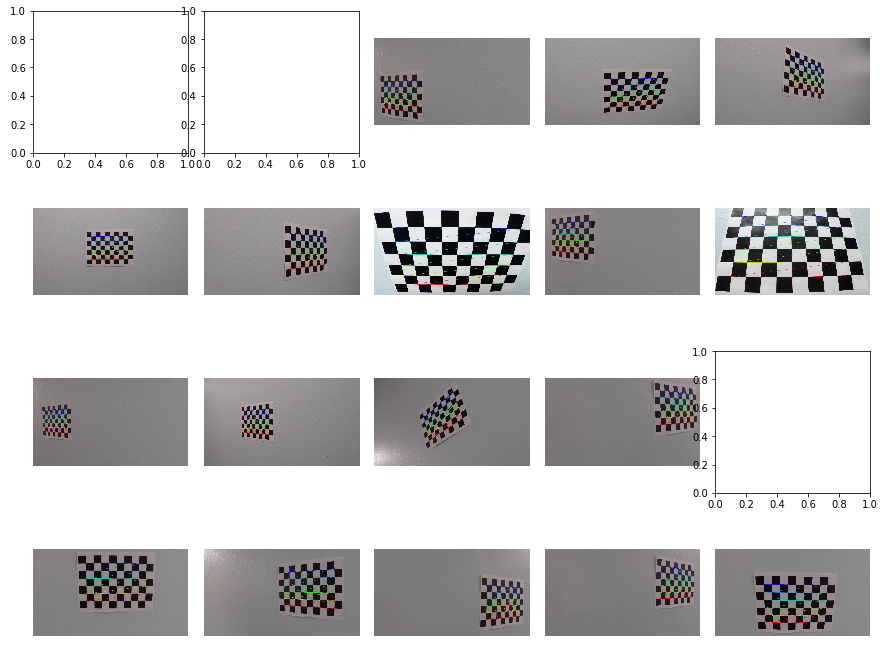

The image below depicts the results of applying `undistort`, using the calibration and distortion coefficients, to one of the chessboard images:

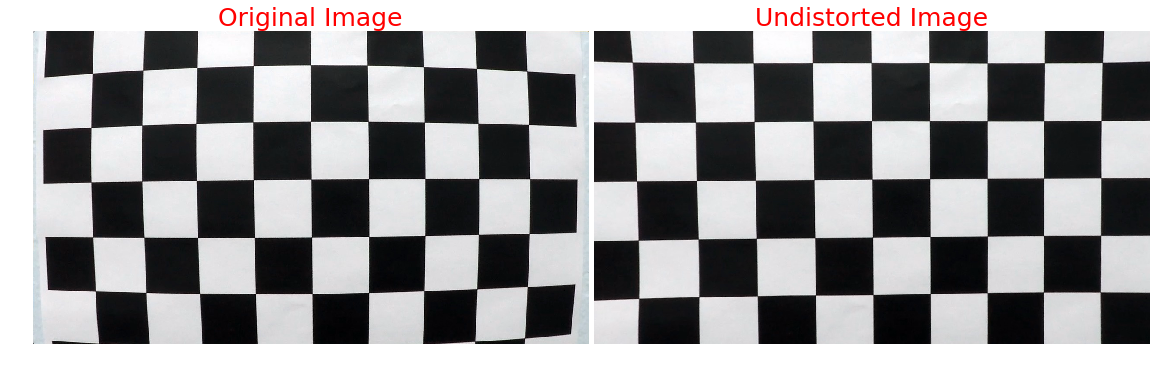

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.

The image below depicts the results of applying `undistort` to one of the project dashcam images (right for the undistorted one left one is the original image):

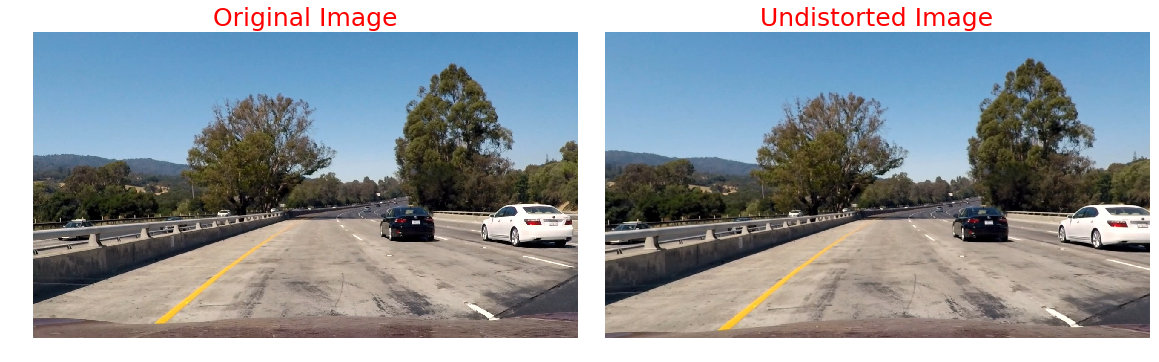

The effect of `undistort` is subtle, but can be perceived from the difference in shape of the hood of the car at the bottom corners of the image.

The below one is the result of the unwarp images which is processed by the perspective transformation.

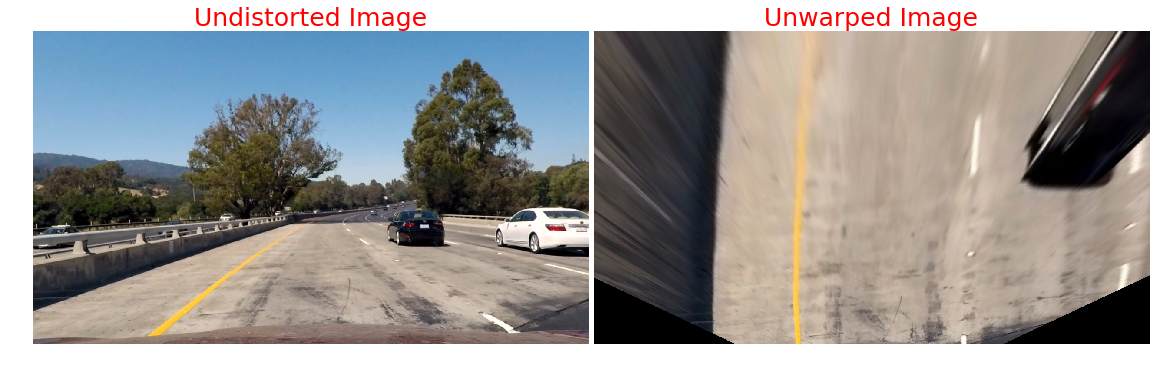

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

I explored several sobel gradient thresholds for mag and direc also, and color channel thresholds in multiple color spaces (RGB,HLS,LAB). These are labeled clearly in the Jupyter notebook. Below are the images precessed by the gradients, gradient mag and gradient direc:

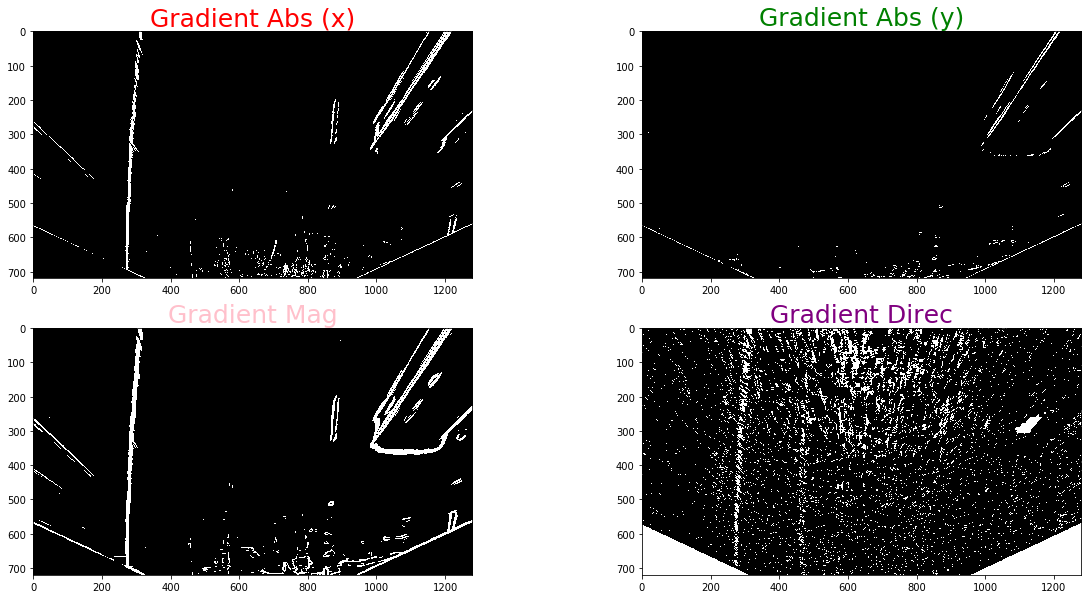


The below image shows the various channels of three different color spaces for the same image:

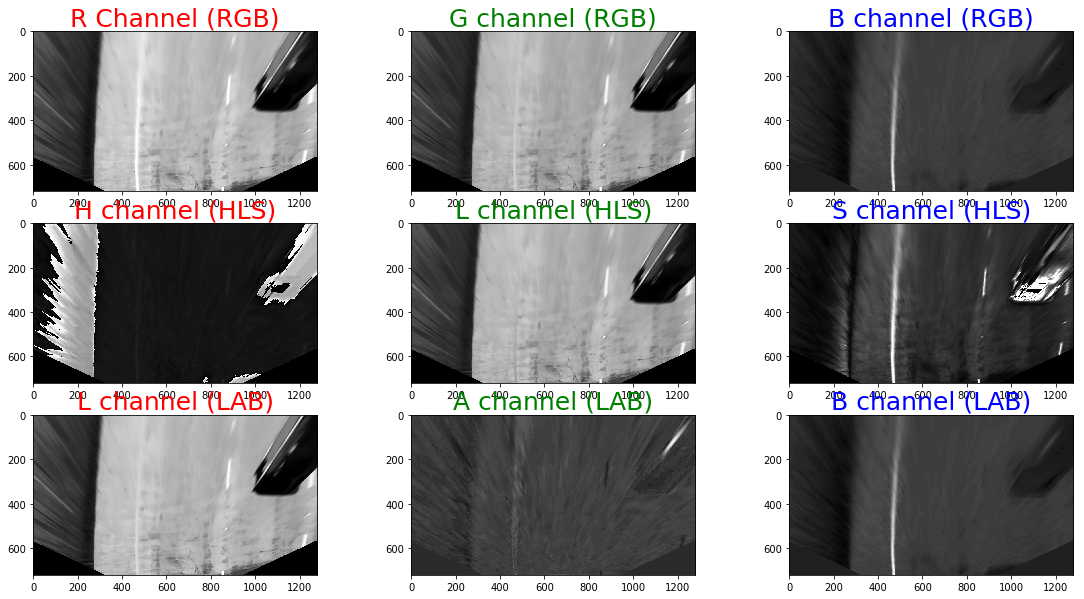

Ultimately, I chose to use just the L channel of the HLS color space to isolate white lines and the B channel of the LAB colorspace to isolate yellow lines. I did not use any gradient thresholds in my pipeline. I did, however finely tune the threshold for each channel to be minimally tolerant to changes in lighting.

Below are the results of applying the binary thresholding pipeline to various sample images:

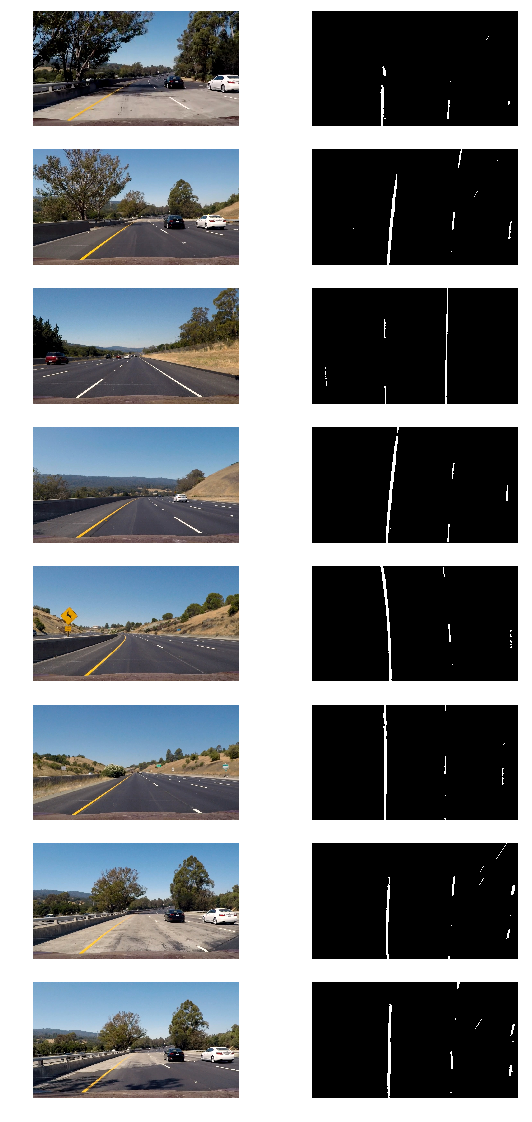

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform is titled "Perspective Transform" in the Jupyter notebook, in the seventh and eighth code cells from the top.  The `unwarp()` function takes as inputs an image (`img`), as well as source (`src`) and destination (`dst`) points.  I chose to hardcode the source and destination points in the following manner:

```
src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])
```
 The image below demonstrates the results of the perspective transform: 
 
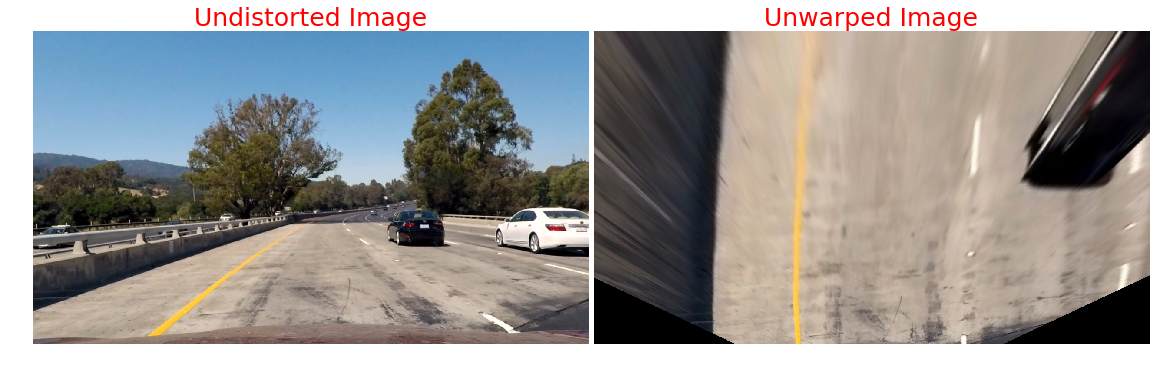

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

The functions `sliding_window_polyfit` and `polyfit_using_prev_fit`, which identify lane lines and fit a second order polynomial to both right and left lane lines, are clearly labeled in the Jupyter notebook as "Sliding Window Polyfit" and "Polyfit Using Fit from Previous Frame". The first of these computes a histogram of the bottom half of the image and finds the bottom-most x position (or "base") of the left and right lane lines. Originally these locations were identified from the local maxima of the left and right halves of the histogram, but in my final implementation I changed these to quarters of the histogram just left and right of the midpoint. This helped to reject lines from adjacent lanes. The function then identifies ten windows from which to identify lane pixels, each one centered on the midpoint of the pixels from the window below. This effectively "follows" the lane lines up to the top of the binary image, and speeds processing by only searching for activated pixels over a small portion of the image. Pixels belonging to each lane line are identified and the Numpy `polyfit()` method fits a second order polynomial to each set of pixels. The image below demonstrates how this process works:

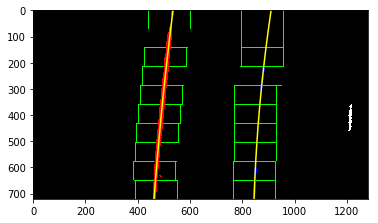

The image below depicts the histogram generated by `sliding_window_polyfit`; the resulting base points for the left and right lanes - the two peaks nearest the center - are clearly visible:

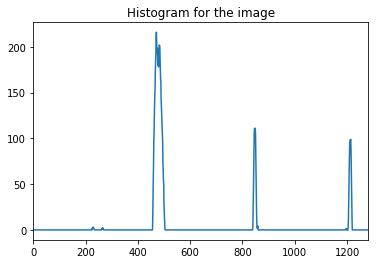

The `polyfit_using_prev_fit` function performs basically the same task, but alleviates much difficulty of the search process by leveraging a previous fit (from a previous video frame, for example) and only searching for lane pixels within a certain range of that fit. The image below demonstrates this - the green shaded area is the range from the previous fit, and the yellow lines and red and blue pixels are from the current image:

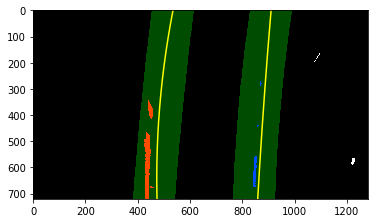

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

The radius of curvature calculated in the code cell titled "Radius of Curvature and Distance from Lane Center Calculation" using this line of code (altered for clarity):
```
curve_radius = ((1 + (2*fit[0]*y_0*y_meters_per_pixel + fit[1])**2)**1.5) / np.absolute(2*fit[0])
```
In this example, `fit[0]` is the first coefficient (the y-squared coefficient) of the second order polynomial fit, and `fit[1]` is the second (y) coefficient. `y_0` is the y position within the image upon which the curvature calculation is based (the bottom-most y - the position of the car in the image - was chosen). `y_meters_per_pixel` is the factor used for converting from pixels to meters. This conversion was also used to generate a new fit with coefficients in terms of meters. 

The position of the vehicle with respect to the center of the lane is calculated with the following lines of code:
```
lane_center_position = (r_fit_x_int + l_fit_x_int) /2
center_dist = (car_position - lane_center_position) * x_meters_per_pix
```
`r_fit_x_int` and `l_fit_x_int` are the x-intercepts of the right and left fits, respectively. This requires evaluating the fit at the maximum y value (719, in this case - the bottom of the image) because the minimum y value is actually at the top (otherwise, the constant coefficient of each fit would have sufficed). The car position is the difference between these intercept points and the image midpoint (assuming that the camera is mounted at the center of the vehicle).

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in the code cells titled "Draw the Detected Lane Back onto the Original Image" and "Draw Curvature Radius and Distance from Center Data onto the Original Image" in the Jupyter notebook. A polygon is generated based on plots of the left and right fits, warped back to the perspective of the original image using the inverse perspective matrix `Minv` and overlaid onto the original image. The image below is an example of the results of the `draw_lane` function:

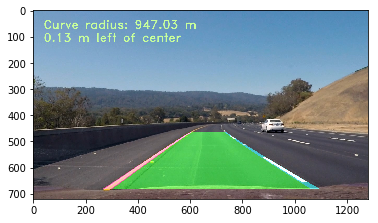

Below is an example of the results of the `draw_data` function, which writes text identifying the curvature radius and vehicle position data onto the original image:

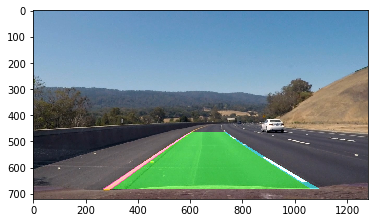
---

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video_output.mp4)

---

### Discussion

Many paramters have to be tuned patiently for the pipelines to give satisfactory results. The advanced pipeline works better by sanity checks, look ahead filter, and smoothing. However, it requires more computation power.

Shadows and steep curves are the hardest to deal with because region masking is no longer sufficient to eliminate noises while preserving lanes. Moreover, shadows shortens true lanes and cast false positives to the binary image. This issue is critical because in the harder video where tight curves and shadows or bright areas casted by the trees exists, it becomes tedious to add more filters and tune them to suit the condition. Also, shrubs around the lane can often trick the lane finder. One possible way is to automate the tuning process in which we rank numerous possible solutions given by several parameter sets. Another is to teach a neural net to assist the lanefinding.

Multiple or better cameras can be used to minimize shadowing effect.